In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !cp -r /content/drive/My\ Drive/CarData/new_car .
# !cp -r /content/drive/My\ Drive/CarData/new_bicycle .
# !cp /content/drive/My\ Drive/CarData/*.jpg .

In [0]:
!ls
# !rm model.h5
# !rm pred_model.h5
# !rm pred_model.json
# %reset

drive  pred_model.h5  pred_model.json  sample_data
rm: cannot remove 'model.h5': No such file or directory


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 30)           8297694     input_1[0][0]                    
                                                                 input_2[0][0]              

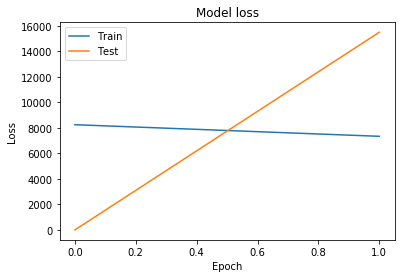

In [0]:
import os
import tensorflow as tf
import time
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import img_to_array

import numpy as np
np.random.seed(int(time.time()))
from keras import backend as K

DATA_PATH = "/content/drive/My Drive/CarData/"

def get_data(name = 'car'):
    data = []
    for file in os.listdir(DATA_PATH + "new_" + name):
        img = load_img(DATA_PATH + "new_"+name+"/" + file)
        img_array = img_to_array(img)
        data.append(img_array)
    return np.array(data)

car_train = get_data()
bicycle_train = get_data('bicycle')

n_car = car_train.shape[0]
n_bicycle = bicycle_train.shape[0]
car_train = car_train[np.random.permutation(np.arange(n_car))[:10]]
bicycle_train = bicycle_train[np.random.permutation(np.arange(n_bicycle))[:10]]
n_car = 10
n_bicycle = 10

X_train = []
y_train = []

for i in range(9):
  for j in range(i+1, 10):
    for k in range(10):
      X_train.append([car_train[i], car_train[j], bicycle_train[k]])

for i in range(9):
  for j in range(i+1, 10):
    for k in range(10):
      X_train.append([bicycle_train[i], bicycle_train[j], car_train[k]])

X_train = np.array(X_train)
y_train = np.empty((X_train.shape[0],))

inds = [i for i in range(X_train.shape[0])]
np.random.shuffle(inds)

X_train = X_train[inds]

from keras.models import Model
from keras.layers import Dense, Flatten, Concatenate, Input, Subtract, Multiply
from keras.optimizers import Adam

from keras.applications.mobilenet import MobileNet

def triplet_loss(y_true, y_pred, alpha=0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
    p_dist = K.sum(K.square(anchor-positive), axis=-1)
    n_dist = K.sum(K.square(anchor-negative), axis=-1)
    return K.sum(K.maximum(p_dist - n_dist + alpha, 0), axis=0)

def get_model(input_shape):
  input1 = Input(shape=input_shape)
  mbnet = MobileNet(input_shape=input_shape, include_top=False)(input1)
  final = Flatten()(mbnet)
  pen = Dense(30, activation="relu")(final)
  model = Model(input1, pen)
  return model


input_1 = Input(shape = X_train[0][0].shape)
input_2 = Input(shape = X_train[0][1].shape)
input_3 = Input(shape = X_train[0][2].shape)

enc_model = get_model(X_train[0][0].shape)

encoding_1 = enc_model(input_1)
encoding_2 = enc_model(input_2)
encoding_3 = enc_model(input_3)

loss_layer = Concatenate(axis=-1)([encoding_1, encoding_2, encoding_3])

# diff = Subtract()([encoding_1, encoding_2])
# sq_diff = Multiply()([diff, diff])
# prediction = Dense(1, activation='sigmoid', name="OutputLayer")(sq_diff)

model = Model([input_1, input_2, input_3], loss_layer)
# pred_model = Model([input_1, input_2], prediction)
print(model.summary())

EPOCHS = 2
model.compile(optimizer=Adam(lr=0.0005), loss=triplet_loss)
# pred_model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy')

if "model.h5" in os.listdir("."):
  model.load_weights("model.h5")

history = model.fit([X_train[:,0], X_train[:,1], X_train[:,2]], y_train, batch_size = 16, epochs=EPOCHS, validation_split=0.1)
model.save_weights("model.h5")
# pred_model.save_weights("pred_model.h5")
# model_json = pred_model.to_json()

# with open("pred_model.json", "w") as json_file:
#     json_file.write(model_json)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# 168756464
%reset_selective -f "^X_train$"
%reset_selective -f "^y_train$"

# from keras.models import model_from_json

def np_triplet_sum(y_pred, alpha=0.2):
    total_lenght = y_pred.shape[-1]
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
    p_dist = np.sum(np.square(anchor-positive), axis=-1)
    n_dist = np.sum(np.square(anchor-negative), axis=-1)
    return np.sum(np.max(p_dist - n_dist + alpha, 0), axis=0)

# json_model_file = open("pred_model.json", 'r')
# json_model = json_model_file.read()
# json_model_file.close()

# pred_model = model_from_json(json_model)
# pred_model.load_weights('pred_model.h5')

# for layer in pred_model.layers:
#   print(layer.name)

img2 = load_img(DATA_PATH + "new_car/1320046908.jpg")
img_array2 = img_to_array(img2)

img3 = load_img(DATA_PATH + "168756464.jpg")
img_array3 = img_to_array(img3)

ans = pred_model.predict([[img_array2], [img_array3]])
print("PREDICTION SAME: ", np.array(ans))

img2 = load_img(DATA_PATH + "new_bicycle/663155599.jpg")
img_array2 = img_to_array(img2)

img3 = load_img(DATA_PATH + "168756464.jpg")
img_array3 = img_to_array(img3)

ans = model.predict([[img_array2], [img_array3]])
print("PREDICTION DIFF: ", np.array(ans))

ValueError: ignored